In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
import xgboost as xgb
from xgboost import XGBClassifier
import torch

In [2]:
df = pd.read_csv("cardio_train.csv", delimiter=";")
df = df.drop(columns=['id'])

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


(None,
      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
 0  18393       2     168    62.0    110     80            1     1      0   
 1  20228       1     156    85.0    140     90            3     1      0   
 2  18857       1     165    64.0    130     70            3     1      0   
 3  17623       2     169    82.0    150    100            1     1      0   
 4  17474       1     156    56.0    100     60            1     1      0   
 
    alco  active  cardio  
 0     0       1       0  
 1     0       1       1  
 2     0       0       1  
 3     0       1       1  
 4     0       0       0  )

In [3]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

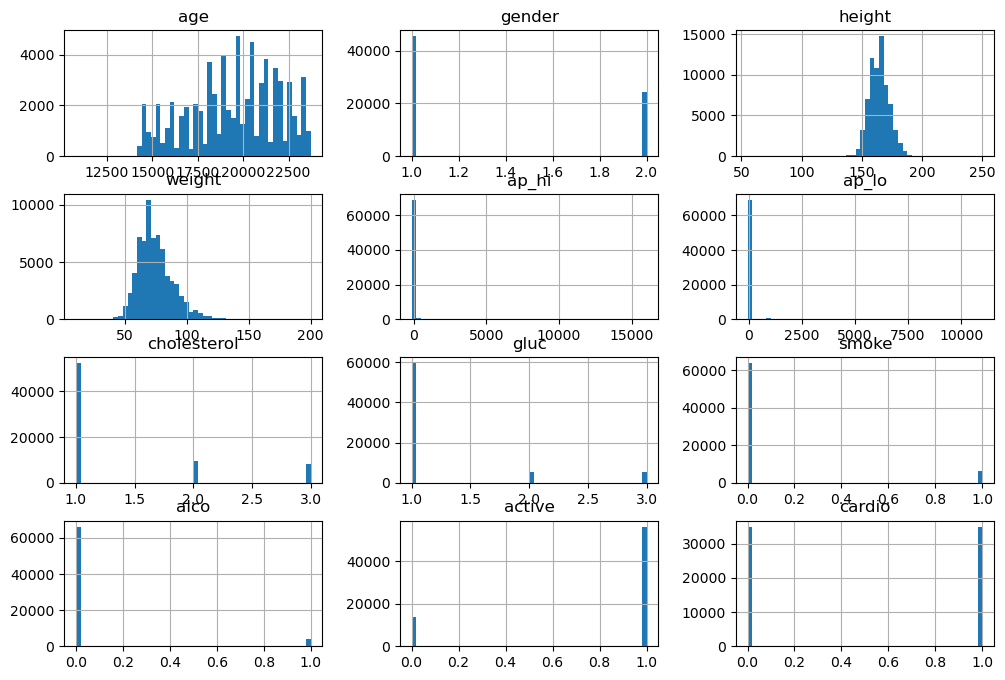

In [4]:
df.hist(bins=50, figsize=(12, 8))
plt.show()

In [5]:
df = df[
    (df.ap_hi.between(70, 200)) &
    (df.ap_lo.between(40, 150)) &
    (df.ap_hi > df.ap_lo)
]

In [6]:
df["gender"] = df["gender"] - 1

In [7]:
df["age"] = df["age"] / 365.25

In [8]:
min_height = df["height"].min()
max_height = df["height"].max()

print(f"Minimum height: {min_height}")
print(f"Maximum height: {max_height}")

Minimum height: 55
Maximum height: 250


In [9]:
df = df[df["height"] >= 80] 

In [10]:
min_weight = df["weight"].min()
max_weight = df["weight"].max()

print(f"Minimum weigth: {min_weight}")
print(f"Maximum weigth: {max_weight}")

Minimum weigth: 11.0
Maximum weigth: 200.0


In [21]:
df = df[df["weight"] >= 40] 

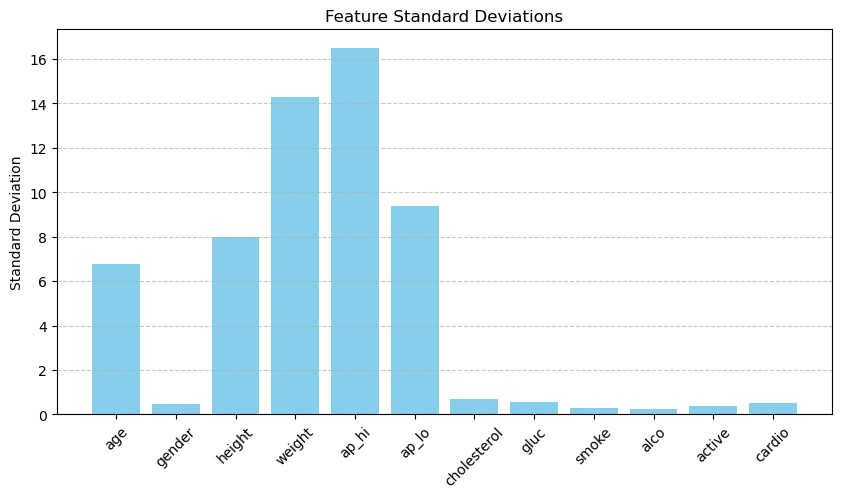

In [23]:
std_devs = df.std()

plt.figure(figsize=(10, 5))
plt.bar(std_devs.index, std_devs.values, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Standard Deviation")
plt.title("Feature Standard Deviations")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [25]:
height_m = df['height'] / 100
df['BMI'] = df['weight'] / (height_m ** 2)
df['BMI'] = df['BMI'].round(2)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 68546 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68546 non-null  float64
 1   gender       68546 non-null  int64  
 2   height       68546 non-null  int64  
 3   weight       68546 non-null  float64
 4   ap_hi        68546 non-null  int64  
 5   ap_lo        68546 non-null  int64  
 6   cholesterol  68546 non-null  int64  
 7   gluc         68546 non-null  int64  
 8   smoke        68546 non-null  int64  
 9   alco         68546 non-null  int64  
 10  active       68546 non-null  int64  
 11  cardio       68546 non-null  int64  
 12  BMI          68546 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 7.3 MB


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000
mean,53.288437,0.348642,164.396551,74.137301,126.611181,81.280731,1.364514,1.225600,0.087985,0.053351,0.803358,0.494617,27.487797
std,6.758160,0.476544,8.003252,14.285852,16.492821,9.368653,0.678830,0.571496,0.283275,0.224734,0.397462,0.499975,5.523511
min,29.563313,0.000000,80.000000,40.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.520000
25%,48.339493,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.880000
50%,53.935661,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.350000
75%,58.381930,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.120000
max,64.922656,1.000000,250.000000,200.000000,200.000000,150.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,278.120000


In [27]:
X = df.drop(columns=['cardio'])
y = df['cardio']

In [29]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=.2, random_state=42)

In [31]:
def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=None):
    assert train_size + val_size + test_size == 1

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42)

In [35]:
lower_hi  = X_train["ap_hi"].quantile(0.005)
upper_hi  = X_train["ap_hi"].quantile(0.995)
lower_lo  = X_train["ap_lo"].quantile(0.005)
upper_lo  = X_train["ap_lo"].quantile(0.995)

mask = (
    (X_train["ap_hi"] >= lower_hi) &
    (X_train["ap_hi"] <= upper_hi) &
    (X_train["ap_lo"] >= lower_lo) &
    (X_train["ap_lo"] <= upper_lo) &
    (X_train["ap_hi"] >  X_train["ap_lo"])
)

X_train = X_train.loc[mask]
y_train = y_train.loc[mask]

print(X_train.shape, y_train.shape)

(54390, 12) (54390,)


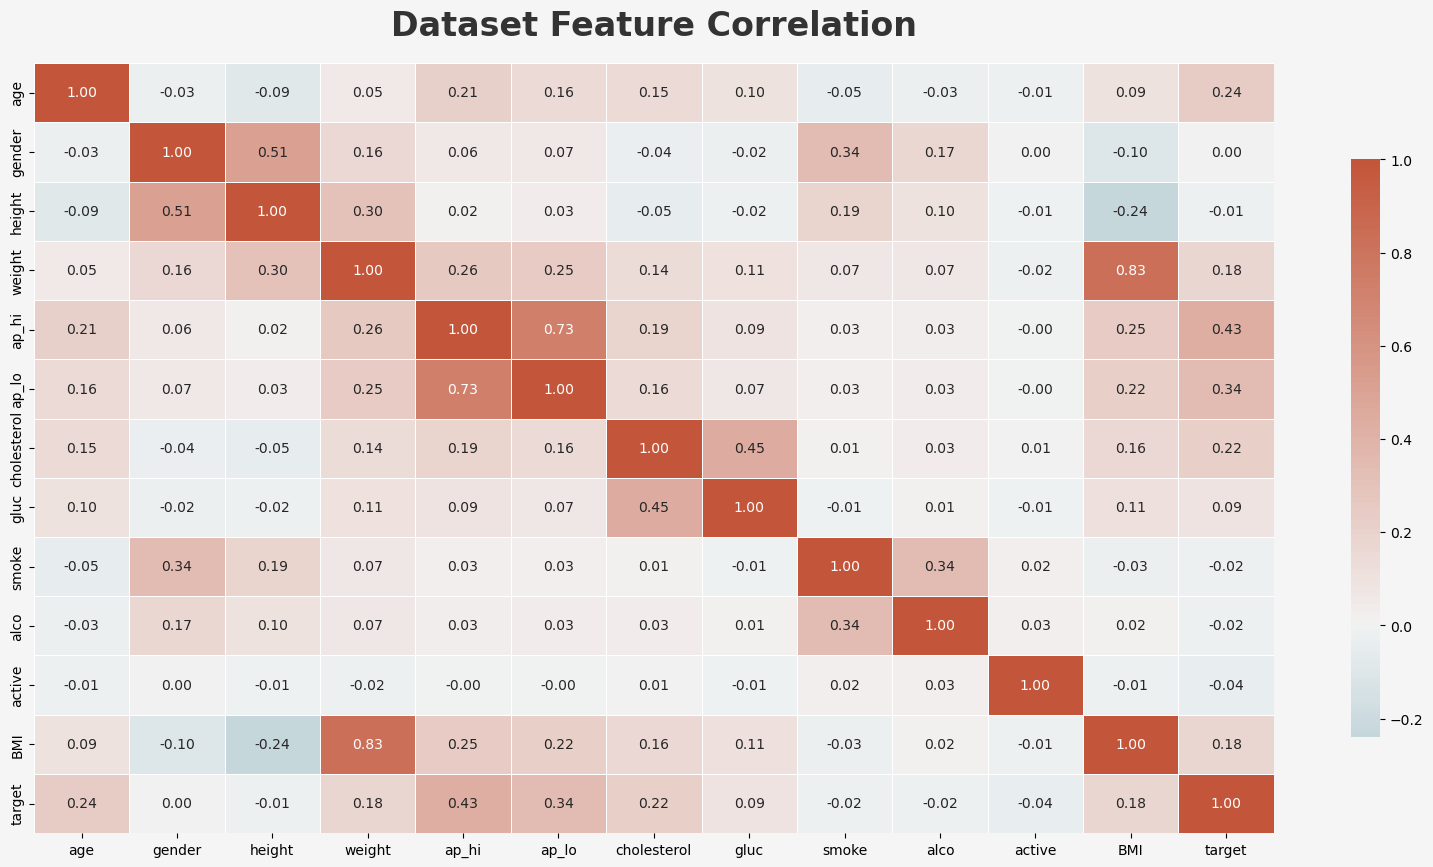

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,target
age,1.000000,-0.025666,-0.085063,0.054293,0.214078,0.156890,0.153537,0.095640,-0.047844,-0.028220,-0.012687,0.094874,0.240187
gender,-0.025666,1.000000,0.507310,0.158058,0.060842,0.065640,-0.035385,-0.022386,0.337723,0.170568,0.003874,-0.103577,0.004672
height,-0.085063,0.507310,1.000000,0.298361,0.016054,0.034532,-0.053041,-0.021305,0.192021,0.097579,-0.011621,-0.239295,-0.013650
weight,0.054293,0.158058,0.298361,1.000000,0.263123,0.245965,0.139472,0.107425,0.069061,0.067518,-0.019681,0.826968,0.175793
ap_hi,0.214078,0.060842,0.016054,0.263123,1.000000,0.726001,0.188203,0.090507,0.025798,0.029730,-0.000358,0.247008,0.431286
ap_lo,0.156890,0.065640,0.034532,0.245965,0.726001,1.000000,0.155723,0.070474,0.025924,0.034283,-0.000258,0.221699,0.339646
cholesterol,0.153537,-0.035385,-0.053041,0.139472,0.188203,0.155723,1.000000,0.450918,0.010608,0.033497,0.006774,0.160353,0.221539
gluc,0.095640,-0.022386,-0.021305,0.107425,0.090507,0.070474,0.450918,1.000000,-0.007931,0.009297,-0.009259,0.114538,0.090518
smoke,-0.047844,0.337723,0.192021,0.069061,0.025798,0.025924,0.010608,-0.007931,1.000000,0.337964,0.024471,-0.029414,-0.019856
alco,-0.028220,0.170568,0.097579,0.067518,0.029730,0.034283,0.033497,0.009297,0.337964,1.000000,0.025417,0.015095,-0.016162


In [37]:
import seaborn as sns

train_data = X_train.copy()
train_data['target'] = y_train

corr_matrix = train_data.corr()

plt.figure(figsize=(20, 10), facecolor='#f5f5f5')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            annot=True, 
            fmt=".2f", 
            cmap=cmap, 
            center=0,
            linewidths=.5, 
            cbar_kws={"shrink": .75})

plt.title("Dataset Feature Correlation", fontsize=24, fontweight='bold', pad=20, color='#333333')

plt.show()

corr_matrix

In [39]:
features = ['age', 'ap_hi', 'ap_lo', 'gender', 'cholesterol', 'BMI', 'gluc', 'smoke', 'alco', 'active']

X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]
X_test_and_val = X_test_and_val[features]

In [41]:
from sklearn.preprocessing import StandardScaler
import joblib
import os

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[features] = scaler.fit_transform(X_train[features])

X_test_scaled = X_test.copy()
X_test_scaled[features] = scaler.transform(X_test[features])

X_val_scaled = X_val.copy()
X_val_scaled[features] = scaler.transform(X_val[features])

X_test_and_val_scaled = X_test_and_val.copy()
X_test_and_val_scaled[features] = scaler.transform(X_test_and_val_scaled[features])

joblib.dump(scaler, 'feature_scaler_new.pkl')

loaded_scaler = joblib.load('feature_scaler_new.pkl')

print("Loaded scaler mean:", loaded_scaler.mean_)
print("Loaded scaler variance:", loaded_scaler.var_)

original_scaled = loaded_scaler.transform(X_train[features])
loaded_scaled = loaded_scaler.transform(X_train[features])

if np.allclose(original_scaled, loaded_scaled):
    print("Verification successful: The scaler works as expected.")
else:
    print("Verification failed: The scaler may not be consistent.")

Loaded scaler mean: [5.32870797e+01 1.26372605e+02 8.11967457e+01 3.48446406e-01
 1.36339401e+00 2.74813208e+01 1.22638353e+00 8.72035301e-02
 5.31163817e-02 8.02555617e-01]
Loaded scaler variance: [4.57454962e+01 2.50674881e+02 8.05707230e+01 2.27031508e-01
 4.60130860e-01 3.05328423e+01 3.28323950e-01 7.95990744e-02
 5.02950317e-02 1.58460099e-01]
Verification successful: The scaler works as expected.


In [43]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54390 entries, 67992 to 16130
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          54390 non-null  float64
 1   ap_hi        54390 non-null  float64
 2   ap_lo        54390 non-null  float64
 3   gender       54390 non-null  float64
 4   cholesterol  54390 non-null  float64
 5   BMI          54390 non-null  float64
 6   gluc         54390 non-null  float64
 7   smoke        54390 non-null  float64
 8   alco         54390 non-null  float64
 9   active       54390 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB


In [45]:
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, log_loss, confusion_matrix
)
from sklearn.calibration import calibration_curve

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.sum(mask) > 0:
            avg_confidence = np.mean(y_prob[mask])
            avg_accuracy = np.mean(y_true[mask])
            ece += np.abs(avg_confidence - avg_accuracy) * np.sum(mask) / len(y_prob)
    return ece

def evaluate_model_performance(y_true, y_pred, y_pred_prob, show_plots=True):
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    brier = brier_score_loss(y_true, y_pred_prob)
    logloss = log_loss(y_true, y_pred_prob)
    ece = expected_calibration_error(y_true, y_pred_prob)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Brier Score: {brier:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    if show_plots:
        frac_pos, mean_pred_val = calibration_curve(y_true, y_pred_prob, n_bins=10)
        plt.figure(figsize=(6, 5))
        plt.plot(mean_pred_val, frac_pos, marker='o', label="Calibration Curve")
        plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Calibration Curve")
        plt.legend()
        plt.grid(True)
        plt.show()


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\ediiz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 90, 'subsample': 0.8}
ROC AUC: 0.8023
Brier Score: 0.1802
Log Loss: 0.5398
Expected Calibration Error (ECE): 0.0102

Confusion Matrix:
[[5463 1545]
 [2122 4580]]


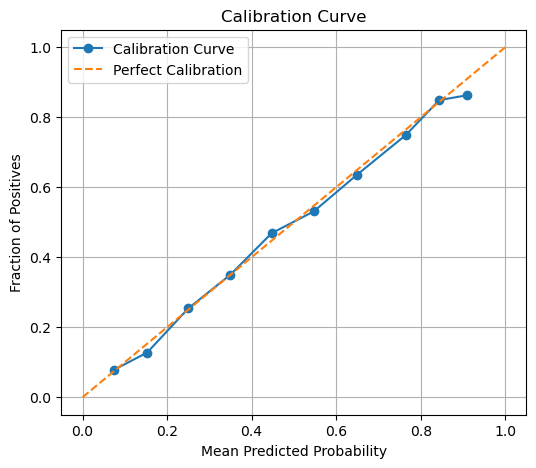

In [87]:
xgb_model_full_set = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'learning_rate': [0.07, 0.08, 0.09],
    'max_depth': [3, 4, 5],
    'n_estimators': [90, 95, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model_full_set,
    param_grid=param_grid,
    scoring=brier_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_and_val_scaled)
y_pred_prob = best_xgb.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 90, 'subsample': 0.8}
ROC AUC: 0.7827
Brier Score: 0.1895
Log Loss: 0.5739
Expected Calibration Error (ECE): 0.0223

Confusion Matrix:
[[2691  828]
 [1090 2246]]


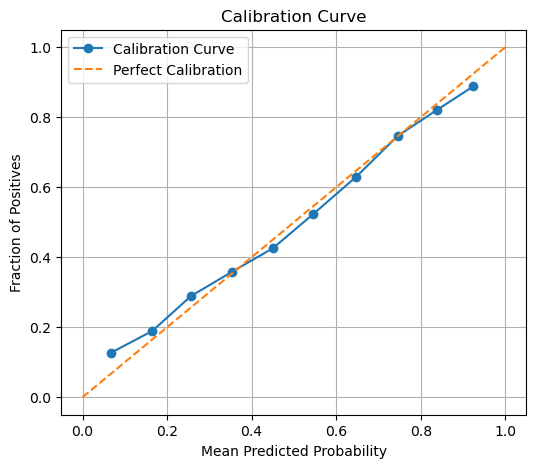

Best number of neighbors: 31


In [89]:
model_name_knn = 'KNeighborsClassifier_GridSearch'

knn_model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': list(range(3, 32, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best Parameters:", grid_search_knn.best_params_)
y_pred = best_knn.predict(X_test_scaled)
y_pred_prob = best_knn.predict_proba(X_test_scaled)[:, 1]

evaluate_model_performance(y_test, y_pred, y_pred_prob)

print(f"Best number of neighbors: {grid_search_knn.best_params_['n_neighbors']}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7}
ROC AUC: 0.7945
Brier Score: 0.1831
Log Loss: 0.5789
Expected Calibration Error (ECE): 0.0074

Confusion Matrix:
[[5533 1475]
 [2252 4450]]


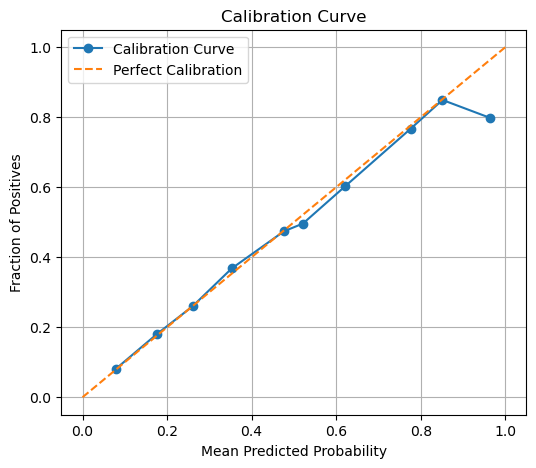

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7}


In [93]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15,],
    'min_samples_split': [2, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_dt.fit(X_train_scaled, y_train)
best_tree = grid_search_dt.best_estimator_
print("Best Parameters:", grid_search_dt.best_params_)
y_pred = best_tree.predict(X_test_and_val_scaled)
y_pred_prob = best_tree.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

print("Best Decision Tree Params:", grid_search_dt.best_params_)

C:\Users\ediiz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.8012
Brier Score: 0.1806
Log Loss: 0.5409
Expected Calibration Error (ECE): 0.0096

Confusion Matrix:
[[5491 1517]
 [2169 4533]]


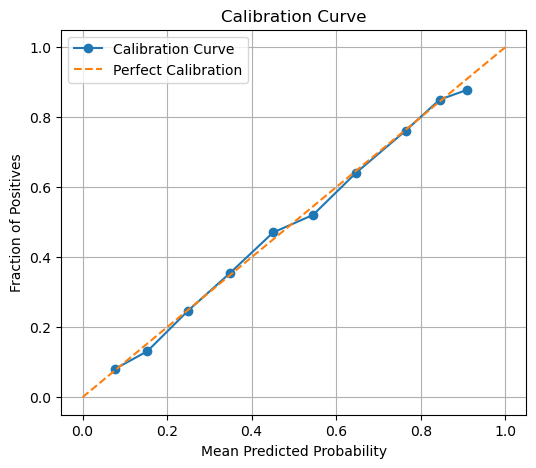

In [95]:
from sklearn.ensemble import VotingClassifier

ensemble_full_set = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('knn', best_knn),
        ('dt', best_tree)
    ],
    voting='soft'
)

ensemble_full_set.fit(X_train_scaled, y_train)

y_pred = ensemble_full_set.predict(X_test_and_val_scaled)
y_pred_prob = ensemble_full_set.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

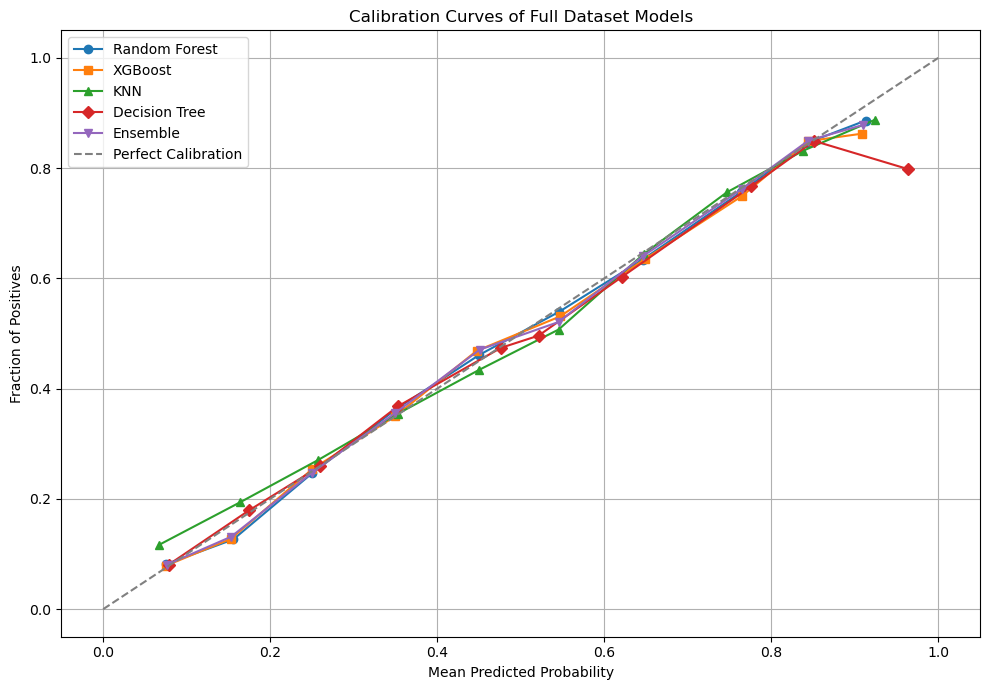

In [97]:
models = [
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb),
    ('KNN', best_knn),
    ('Decision Tree', best_tree),
    ('Ensemble', ensemble_full_set)
]

markers = ['o', 's', '^', 'D', 'v']

plt.figure(figsize=(10, 7))

for (name, model), marker in zip(models, markers):
    y_pred_prob = model.predict_proba(X_test_and_val_scaled)[:, 1]
    frac_pos, mean_pred_val = calibration_curve(y_test_and_val, y_pred_prob, n_bins=10)
    plt.plot(mean_pred_val, frac_pos, marker=marker, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves of Full Dataset Models")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

ROC AUC: 0.8022
Brier Score: 0.1803
Log Loss: 0.5401
Expected Calibration Error (ECE): 0.0079

Confusion Matrix:
[[5454 1554]
 [2099 4603]]


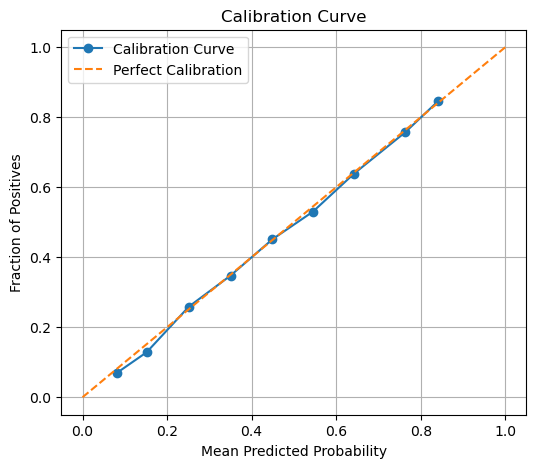

In [69]:
xg_boost = XGBClassifier(verbosity=1, n_estimators=95,
                            gamma= 0.3, max_depth=4, learning_rate=0.08,
                            reg_lambda=100, scale_pos_weight=1, random_state=42)

xg_boost.fit(X_train_scaled, y_train)
y_pred = xg_boost.predict(X_test_and_val_scaled)
y_pred_prob = xg_boost.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Accuracy: 0.7292
Precision: 0.7700
Recall: 0.6471
F1 Score: 0.7032
ROC AUC: 0.7967
PR AUC: 0.7786
Brier Score: 0.1837
Expected Calibration Error (ECE): 0.0301

Confusion Matrix:
[[5608 1316]
 [2402 4405]]


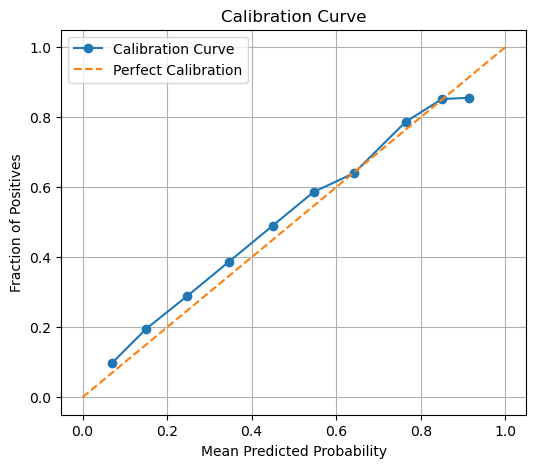

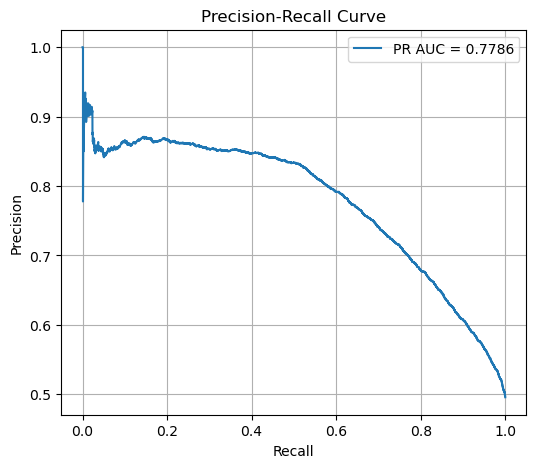

Best Refined MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (16,), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_iter': 400, 'solver': 'adam'}


In [77]:
param_grid_mlp_refined = {
    'hidden_layer_sizes': [
        (16,),
        (32,),
        (64,),
        (32, 16),
        (64, 32),
    ],
    'activation': ['relu'],
    'alpha': [0.0001, 0.0005, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.005],
    'solver': ['adam'],
    'max_iter': [400]  
}

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)

grid_search_mlp_refined = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp_refined,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp_refined.fit(X_train_scaled, y_train)

best_mlp_refined = grid_search_mlp_refined.best_estimator_
y_pred = best_mlp_refined.predict(X_test_and_val_scaled)
y_pred_prob = best_mlp_refined.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

print("Best Refined MLP Params:", grid_search_mlp_refined.best_params_)


Accuracy: 0.7333
Precision: 0.7610
Recall: 0.6736
F1 Score: 0.7146
ROC AUC: 0.7997
PR AUC: 0.7838
Brier Score: 0.1815
Expected Calibration Error (ECE): 0.0081

Confusion Matrix:
[[5484 1440]
 [2222 4585]]


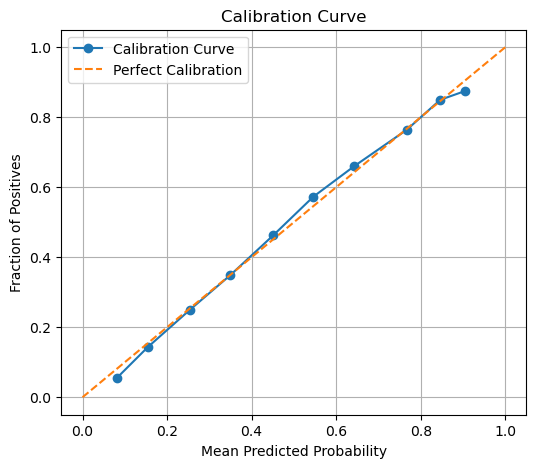

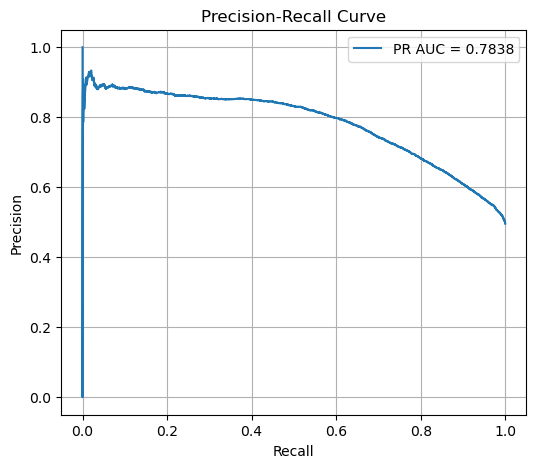

In [79]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


random_forest = RandomForestClassifier(criterion='log_loss', max_depth= 10,
                                       max_features='log2',n_estimators=100)
xg_boost = XGBClassifier(verbosity=1, n_estimators=95,
                            gamma= 0.3, max_depth=4, learning_rate=0.08,
                            reg_lambda=100, scale_pos_weight=1, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(32,),learning_rate='constant', activation='relu', alpha=0.001, learning_rate_init= 0.005,
                    max_iter=300, solver='adam', random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', random_forest), ('xgb', xg_boost), ('mlp', mlp)],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train_scaled, y_train)
y_pred = ensemble.predict(X_test_and_val_scaled)
y_pred_prob = ensemble.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

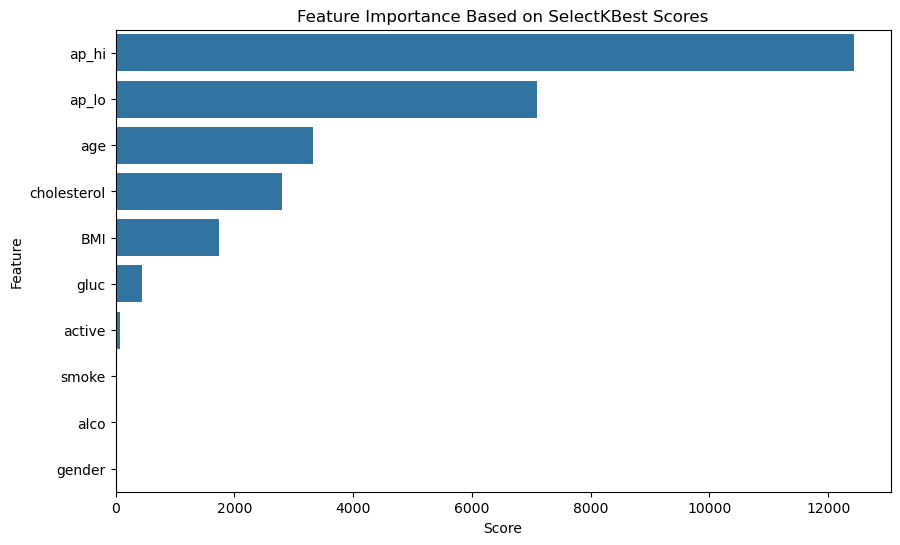

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k="all")
selector.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    "Feature": X_train.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Feature", data=feature_scores)
plt.title("Feature Importance Based on SelectKBest Scores")
plt.show()

In [51]:
X_train = X_train[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]
X_test = X_test[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]
X_val = X_val[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]
X_test_and_val = X_test_and_val[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]

In [53]:
print(X_train.columns)
print(X_test.columns)
print(X_val.columns)
print(X_test_and_val.columns)

print(X_train_scaled.columns)

Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'gender', 'cholesterol', 'BMI', 'gluc',
       'smoke', 'alco', 'active'],
      dtype='object')


In [55]:
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI']

In [57]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = X_test.copy()
X_test_scaled = scaler.transform(X_test)

X_val_scaled = X_val.copy()
X_val_scaled = scaler.transform(X_val)

X_test_and_val_scaled = X_test_and_val.copy()
X_test_and_val_scaled = scaler.transform(X_test_and_val)

joblib.dump(scaler, 'feature_scaler_modif.pkl')

loaded_scaler = joblib.load('feature_scaler_modif.pkl')

print("Loaded scaler mean:", loaded_scaler.mean_)
print("Loaded scaler variance:", loaded_scaler.var_)

original_scaled = loaded_scaler.transform(X_train)
loaded_scaled = loaded_scaler.transform(X_train)

if np.allclose(original_scaled, loaded_scaled):
    print("Verification successful: The scaler works as expected.")
else:
    print("Verification failed: The scaler may not be consistent.")

Loaded scaler mean: [ 53.28707966 126.37260526  81.19674573   1.36339401  27.48132083]
Loaded scaler variance: [ 45.74549624 250.67488108  80.570723     0.46013086  30.53284234]
Verification successful: The scaler works as expected.


C:\Users\ediiz\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ediiz\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ediiz\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ediiz\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ediiz\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

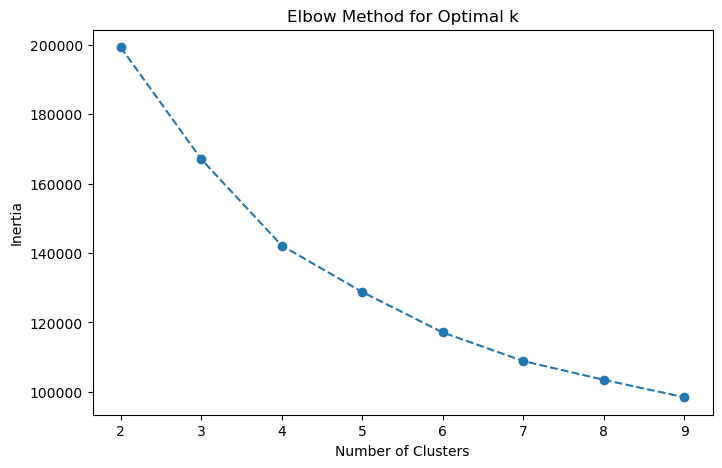

In [59]:
from sklearn.cluster import KMeans
import warnings\

inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [61]:
import pickle
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_and_val_scaled = pd.DataFrame(X_test_and_val_scaled, columns=X_test_and_val.columns, index=X_test_and_val.index)

X_train_scaled.columns = X_train_scaled.columns.astype(str)
X_test_scaled.columns = X_test_scaled.columns.astype(str)
X_val_scaled.columns = X_val_scaled.columns.astype(str)
X_test_and_val_scaled.columns = X_test_and_val_scaled.columns.astype(str)

k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, init="k-means++", random_state=42, n_init=10)
X_train_scaled["Cluster"] = kmeans_final.fit_predict(X_train_scaled)

X_test_scaled["Cluster"] = kmeans_final.predict(X_test_scaled)
X_val_scaled["Cluster"] = kmeans_final.predict(X_val_scaled)
X_test_and_val_scaled["Cluster"] = kmeans_final.predict(X_test_and_val_scaled)

X_train["Cluster"] = X_train_scaled["Cluster"]
X_test["Cluster"] = X_test_scaled["Cluster"]
X_val["Cluster"] = X_val_scaled["Cluster"]
X_test_and_val["Cluster"] = X_test_and_val_scaled["Cluster"]

cluster_scaler = MinMaxScaler()
X_train_scaled["Cluster"] = cluster_scaler.fit_transform(X_train_scaled[["Cluster"]])
X_test_scaled["Cluster"] = cluster_scaler.transform(X_test_scaled[["Cluster"]])
X_val_scaled["Cluster"] = cluster_scaler.transform(X_val_scaled[["Cluster"]])
X_test_and_val_scaled["Cluster"] = cluster_scaler.transform(X_test_and_val_scaled[["Cluster"]])

with open("cluster_scaler_modif.pkl", "wb") as scaler_file:
    pickle.dump(cluster_scaler, scaler_file)

with open("kmeans_model_modif.pkl", "wb") as kmeans_file:
    pickle.dump(kmeans_final, kmeans_file)

print("Train Cluster Distribution:\n", X_train_scaled["Cluster"].value_counts())


Train Cluster Distribution:
 Cluster
1.0    32085
0.0    13574
0.5     8731
Name: count, dtype: int64


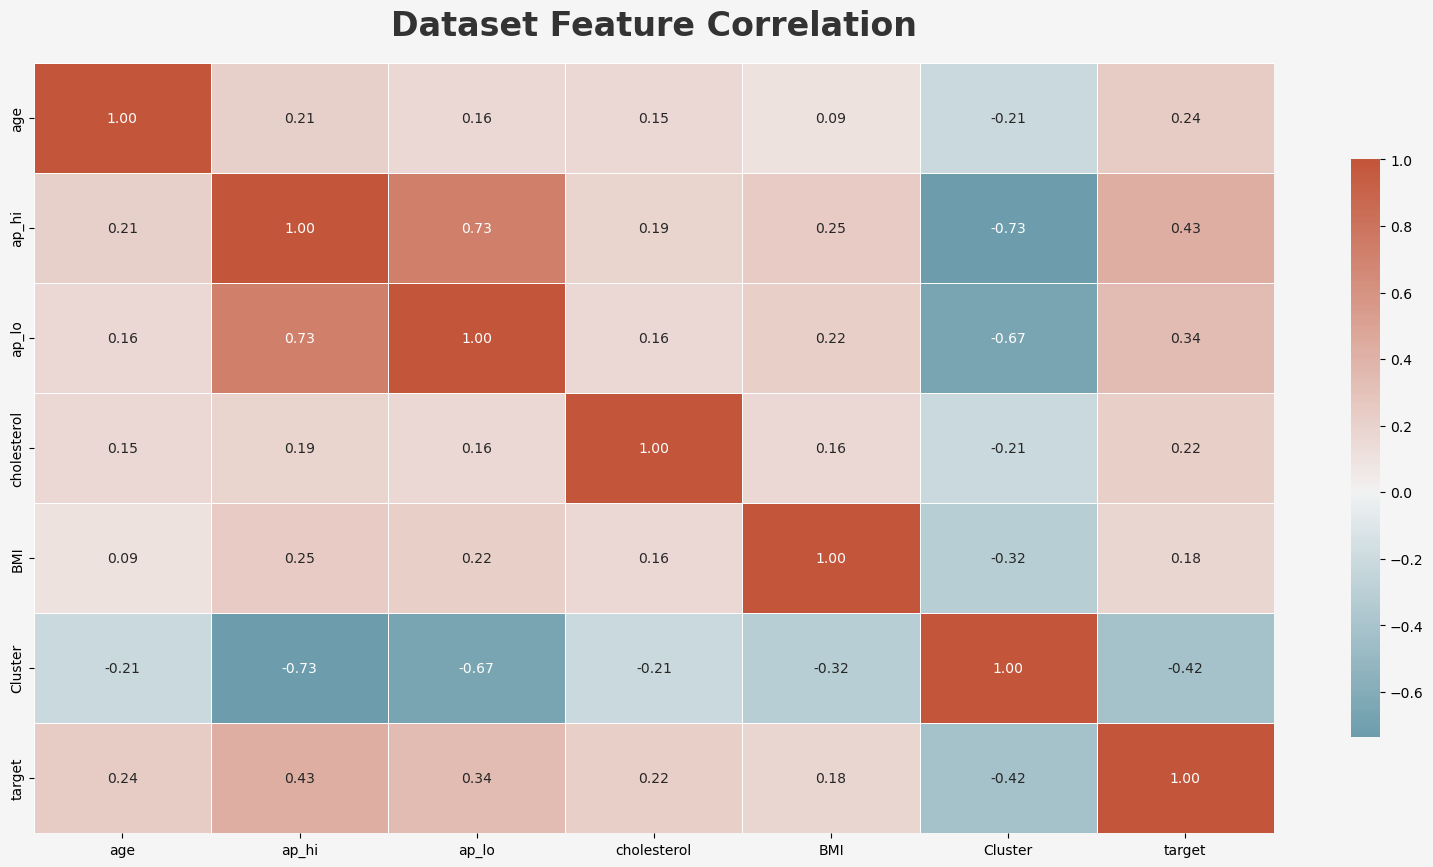

,age,ap_hi,ap_lo,cholesterol,BMI,Cluster,target
age,1.000000,0.214078,0.156890,0.153537,0.094874,-0.211857,0.240187
ap_hi,0.214078,1.000000,0.726001,0.188203,0.247008,-0.734921,0.431286
ap_lo,0.156890,0.726001,1.000000,0.155723,0.221699,-0.665646,0.339646
cholesterol,0.153537,0.188203,0.155723,1.000000,0.160353,-0.208405,0.221539
BMI,0.094874,0.247008,0.221699,0.160353,1.000000,-0.318848,0.176535
Cluster,-0.211857,-0.734921,-0.665646,-0.208405,-0.318848,1.000000,-0.424396
target,0.240187,0.431286,0.339646,0.221539,0.176535,-0.424396,1.000000


In [63]:
train_data = X_train_scaled.copy()
train_data['target'] = y_train

corr_matrix = train_data.corr()

plt.figure(figsize=(20, 10), facecolor='#f5f5f5')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            annot=True, 
            fmt=".2f", 
            cmap=cmap, 
            center=0,
            linewidths=.5, 
            cbar_kws={"shrink": .75})

plt.title("Dataset Feature Correlation", fontsize=24, fontweight='bold', pad=20, color='#333333')

plt.show()

corr_matrix

Best Parameters: {'n_neighbors': 31, 'p': 2, 'weights': 'uniform'}
ROC AUC: 0.7854
Brier Score: 0.1880
Log Loss: 0.5996
Expected Calibration Error (ECE): 0.0255

Confusion Matrix:
[[2712  807]
 [1081 2255]]


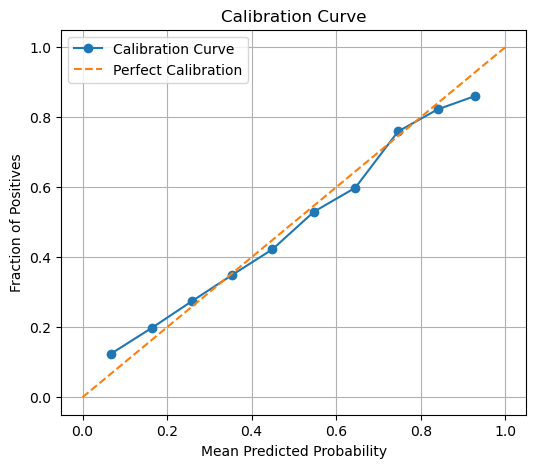

Best number of neighbors: 31


In [63]:
model_name_knn = 'KNeighborsClassifier_GridSearch'

knn_model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': list(range(3, 32, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best Parameters:", grid_search_knn.best_params_)
y_pred = best_knn.predict(X_test_scaled)
y_pred_prob = best_knn.predict_proba(X_test_scaled)[:, 1]

evaluate_model_performance(y_test, y_pred, y_pred_prob)

print(f"Best number of neighbors: {grid_search_knn.best_params_['n_neighbors']}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best ROC AUC Score: 0.7966666859370163
Best Parameters: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 95}
ROC AUC: 0.7990
Brier Score: 0.1816
Log Loss: 0.5430
Expected Calibration Error (ECE): 0.0078

Confusion Matrix:
[[5440 1568]
 [2133 4569]]


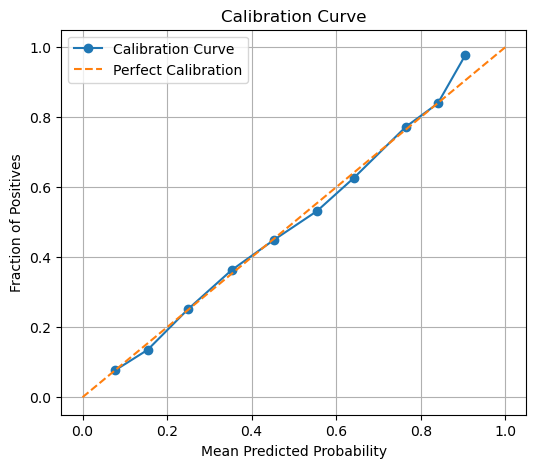

In [70]:
xgb_model = XGBClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators': [95, 100, 105]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=2 
)

grid_search.fit(X_train_scaled, y_train)

print("Best ROC AUC Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

best_xgb_model_reduced = grid_search.best_estimator_

y_pred = best_xgb_model_reduced.predict(X_test_and_val_scaled)
y_pred_prob = best_xgb_model_reduced.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

ROC AUC: 0.7993
Brier Score: 0.1814
Log Loss: 0.5425
Expected Calibration Error (ECE): 0.0065

Confusion Matrix:
[[5450 1558]
 [2136 4566]]


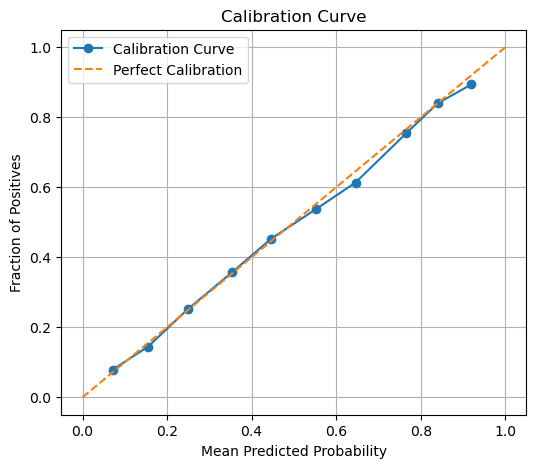

In [74]:
from joblib import dump, load
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgb = CalibratedClassifierCV(best_xgb_model_reduced, method='isotonic', cv=10)
calibrated_xgb.fit(X_train_scaled, y_train)

y_pred_prob_calibrated = calibrated_xgb.predict_proba(X_test_and_val_scaled)[:, 1]
y_pred_calibrated = calibrated_xgb.predict(X_test_and_val_scaled)

dump(calibrated_xgb, "xgb_calibrated.joblib")
calibrated_xgb = load("xgb_calibrated.joblib")

evaluate_model_performance(y_test_and_val, y_pred_calibrated, y_pred_prob_calibrated)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 150}
ROC AUC: 0.7983
Brier Score: 0.1821
Log Loss: 0.5444
Expected Calibration Error (ECE): 0.0110

Confusion Matrix:
[[5556 1452]
 [2255 4447]]


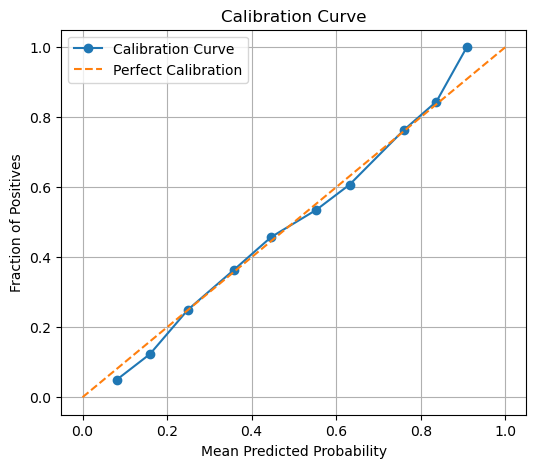

In [69]:
from sklearn.metrics import make_scorer

random_forest_full_set = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 120, 150],
    'max_depth': [5, 8, 10, 12],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['log_loss']
}

brier_scorer = make_scorer(brier_score_loss, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=random_forest_full_set,
    param_grid=param_grid,
    scoring=brier_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_and_val_scaled)
y_pred_prob = best_rf.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 26895, number of negative: 27495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 54390, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494484 -> initscore=-0.022064
[LightGBM] [Info] Start training from score -0.022064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

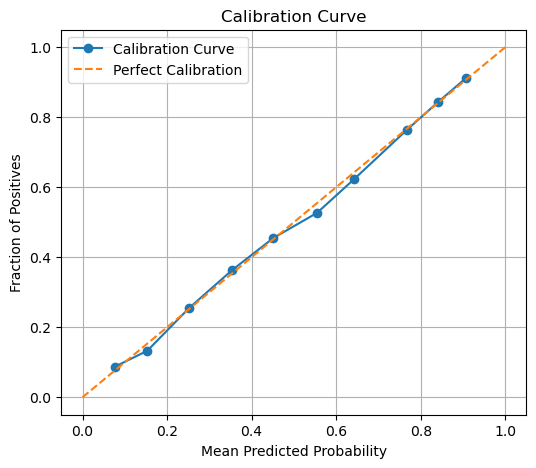

In [145]:
param_grid_lgbm = {
    'max_depth':     [3, 4, 5],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators':  [95, 100, 105]
}

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_classifier,
    param_grid=param_grid_lgbm,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_lgbm.fit(X_train_scaled, y_train)

print("Best ROC AUC Score (LightGBM):", grid_search_lgbm.best_score_)
print("Best Parameters (LightGBM):", grid_search_lgbm.best_params_)

best_lgbm_model = grid_search_lgbm.best_estimator_
y_pred_lgbm      = best_lgbm_model.predict(X_test_and_val_scaled)
y_pred_prob_lgbm = best_lgbm_model.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred_lgbm, y_pred_prob_lgbm)

[LightGBM] [Info] Number of positive: 24205, number of negative: 24746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 48951, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494474 -> initscore=-0.022105
[LightGBM] [Info] Start training from score -0.022105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

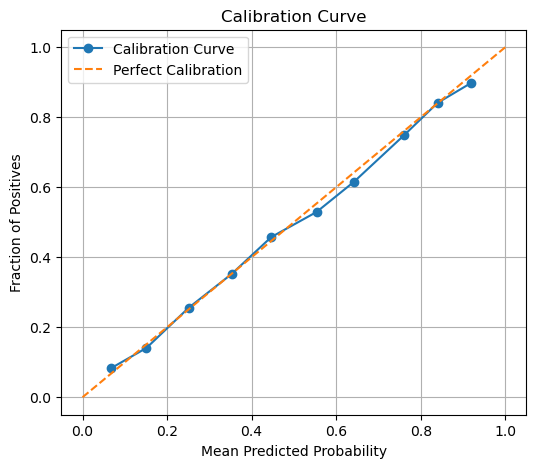

In [147]:
calibrated_lgbm = CalibratedClassifierCV(
    estimator=best_lgbm_model,
    method='isotonic',
    cv=10
)

calibrated_lgbm.fit(X_train_scaled, y_train)

dump(calibrated_lgbm, "lgbm_calibrated.joblib")

calibrated_lgbm = load("lgbm_calibrated.joblib")

y_pred_calibrated_lgbm      = calibrated_lgbm.predict(X_test_and_val_scaled)
y_pred_prob_calibrated_lgbm = calibrated_lgbm.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(
    y_true=y_test_and_val,
    y_pred=y_pred_calibrated_lgbm,
    y_pred_prob=y_pred_prob_calibrated_lgbm
)

In [91]:
from pytorch_tabnet.tab_model import TabNetClassifier

X_train_np = X_train_scaled.values
y_train_np = y_train.values

X_val_np = X_val_scaled.values
y_val_np = y_val.values

X_test_np = X_test_scaled.values
y_test_np = y_test.values


tabnet_clf = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-3,
    n_shared=2,
    n_independent=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-3),
    mask_type='entmax',
    scheduler_params={"step_size": 20, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=20,
    batch_size=128,
    virtual_batch_size=64
)


y_test_pred = tabnet_clf.predict(X_test_np)
y_test_proba = tabnet_clf.predict_proba(X_test_np)[:, 1]

C:\Users\ediiz\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57607 | val_auc: 0.79976 |  0:00:11s
epoch 1  | loss: 0.55681 | val_auc: 0.80251 |  0:00:22s
epoch 2  | loss: 0.55448 | val_auc: 0.80311 |  0:00:33s
epoch 3  | loss: 0.55361 | val_auc: 0.80217 |  0:00:44s
epoch 4  | loss: 0.55256 | val_auc: 0.80075 |  0:00:56s
epoch 5  | loss: 0.55275 | val_auc: 0.80434 |  0:01:07s
epoch 6  | loss: 0.55291 | val_auc: 0.80154 |  0:01:19s
epoch 7  | loss: 0.55196 | val_auc: 0.79983 |  0:01:30s
epoch 8  | loss: 0.55144 | val_auc: 0.8038  |  0:01:42s
epoch 9  | loss: 0.55224 | val_auc: 0.80117 |  0:01:53s
epoch 10 | loss: 0.55238 | val_auc: 0.80388 |  0:02:05s
epoch 11 | loss: 0.55216 | val_auc: 0.80344 |  0:02:17s
epoch 12 | loss: 0.55096 | val_auc: 0.80331 |  0:02:28s
epoch 13 | loss: 0.55001 | val_auc: 0.80297 |  0:02:40s
epoch 14 | loss: 0.55005 | val_auc: 0.80381 |  0:02:52s
epoch 15 | loss: 0.54987 | val_auc: 0.80323 |  0:03:04s
epoch 16 | loss: 0.54952 | val_auc: 0.80309 |  0:03:15s
epoch 17 | loss: 0.54929 | val_auc: 0.80313 |  0

C:\Users\ediiz\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


ROC AUC: 0.7913
Brier Score: 0.1847
Log Loss: 0.5504
Expected Calibration Error (ECE): 0.0148

Confusion Matrix:
[[2752  767]
 [1114 2222]]


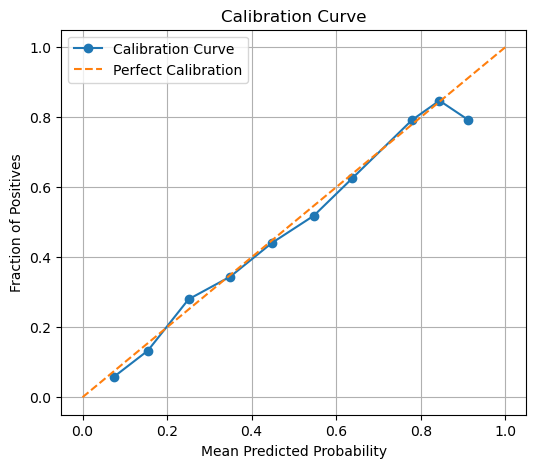

In [87]:
evaluate_model_performance(y_test_np, y_test_pred, y_test_proba)

ROC AUC: 0.7890
Brier Score: 0.1854
Log Loss: 0.5543
Expected Calibration Error (ECE): 0.0163

Confusion Matrix:
[[2824  695]
 [1183 2153]]


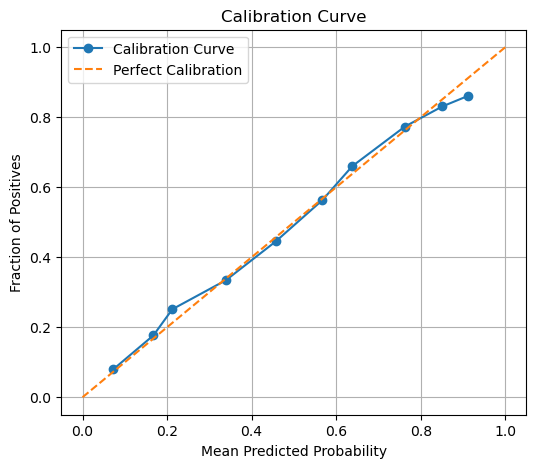

In [89]:
from sklearn.isotonic import IsotonicRegression

val_preds_proba = tabnet_clf.predict_proba(X_val_np)[:, 1]

iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(val_preds_proba, y_val_np)

test_preds_proba_raw = tabnet_clf.predict_proba(X_test_np)[:, 1]
test_preds_proba_calibrated = iso_reg.transform(test_preds_proba_raw)

test_preds_calibrated = (test_preds_proba_calibrated >= 0.5).astype(int)

evaluate_model_performance(y_test, test_preds_calibrated, test_preds_proba_calibrated)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
ROC AUC: 0.7985
Brier Score: 0.1817
Log Loss: 0.5433
Expected Calibration Error (ECE): 0.0119

Confusion Matrix:
[[5500 1508]
 [2200 4502]]


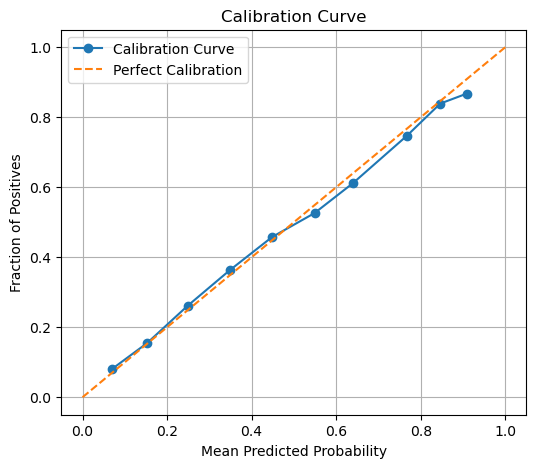

Best Refined MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (16, 8), 'learning_rate': 'constant', 'learning_rate_init': 0.003, 'max_iter': 150, 'solver': 'adam'}


In [71]:
param_grid_mlp_refined = {
    'hidden_layer_sizes': [
        (8,), (16,), (32,),
        (16, 8), (32, 16)
    ],
    'activation': ['relu'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.002, 0.003, 0.005],
    'solver': ['adam'],
    'max_iter': [150]
}

mlp = MLPClassifier(random_state=42)

grid_search_mlp_refined = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp_refined,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp_refined.fit(X_train_scaled, y_train)

best_mlp_refined = grid_search_mlp_refined.best_estimator_
y_pred = best_mlp_refined.predict(X_test_and_val_scaled)
y_pred_prob = best_mlp_refined.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

print("Best Refined MLP Params:", grid_search_mlp_refined.best_params_)


Epoch 1/100


C:\Users\ediiz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


850/850 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5750 - val_loss: 0.5430
Epoch 2/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5536 - val_loss: 0.5435
Epoch 3/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5501 - val_loss: 0.5416
Epoch 4/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5536 - val_loss: 0.5412
Epoch 5/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5516 - val_loss: 0.5402
Epoch 6/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5482 - val_loss: 0.5419
Epoch 7/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5492 - val_loss: 0.5392
Epoch 8/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5479 - val_loss: 0.5382
Epoch 9/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5497 - val_loss: 0.5401
Epoch 10/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5507 - val_loss: 0.5386
Epoch 11/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5487 - val_loss: 0.5406
Epoch 12/100
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

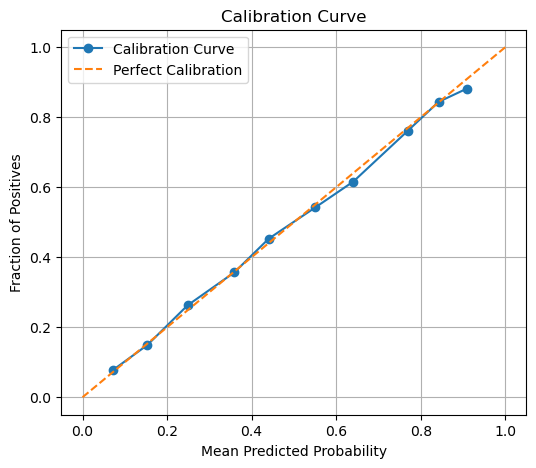

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

X_test_and_val = np.vstack([X_val_scaled, X_test_scaled])
y_test_and_val = np.concatenate([y_val, y_test])

y_proba = model.predict(X_test_and_val).flatten()
y_pred = (y_proba >= 0.5).astype(int)

evaluate_model_performance(y_test_and_val, y_pred, y_proba)